# Import packages

In [5]:
#import basic python packages
import requests
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date, timedelta
import geopandas as gpd
# import modeling packages
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline 
from sklearn.impute import KNNImputer, SimpleImputer 
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, plot_confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
# import API package
import covidcast
# pandas view options
pd.set_option('display.max_columns', 100)

# Data Wrangling

### API Call For Covid Survey Data on Mask Use

In [6]:
# create variable to hold date object for two days ago
two_days_ago = date.today() - timedelta(days=2)

In [7]:
# get the most recent survey data
mask_ind = covidcast.signal("fb-survey", "smoothed_wearing_mask",
                            date(2020, 10, 1), two_days_ago,
                            "county")
mask_oth = covidcast.signal('fb-survey', 'smoothed_others_masked', 
                            date(2020, 11, 24),two_days_ago, 
                            "county")

In [8]:
# remove data that isn't at the county level
mask_fip = mask_ind.loc[~mask_ind.geo_value.str.endswith('000')]
mask_oth = mask_oth.loc[~mask_oth.geo_value.str.endswith('000')]

In [9]:
# check number of counties represented 
print(mask_fip.geo_value.value_counts().shape)
mask_oth.geo_value.value_counts().shape

(677,)


(655,)

In [10]:
# pare down datasets to just columns of interest
mask_ind_means = pd.DataFrame(mask_fip.groupby(['geo_value'])['value'].mean()).reset_index()
mask_ind_means.columns = ['FIPS', 'ind_mask']
mask_ind_means['FIPS'] = mask_ind_means['FIPS'].astype(int)
# repeat for other survey
mask_oth_means = pd.DataFrame(mask_oth.groupby(['geo_value'])['value'].mean()).reset_index()
mask_oth_means.columns = ['FIPS', 'oth_mask']
mask_oth_means['FIPS'] = mask_oth_means['FIPS'].astype(int)

In [11]:
# merge 'individual' and 'other' mask survey data
mask_means = mask_ind_means.merge(mask_oth_means, on = 'FIPS', how = 'outer')

### Import Kaggle Election Dataset 

In [12]:
election = pd.read_csv('data/county_statistics.csv', index_col="Unnamed: 0")

In [13]:
# remove unusable county rows
election = election[election.county != 'Unassigned']
# create single county, state column to in prep for eventual merge with API dataset
election['county'] = election['county'] + ', ' + election['state']
election.drop(['state'], axis=1, inplace=True)
# select needed columns
to_keep = ['county', 'total_votes16', 'total_votes20' , 'percentage20_Joe_Biden']
merge_elec = election[to_keep]

### Import Rural-Urban Contiuum dataset 

In [14]:
rural_urban = pd.read_excel('data/ru_code.xls')
# select features
fip_rur = rural_urban[['FIPS', 'RUCC_2013']]

### Import Geopandas file with wider population data

In [15]:
geo = gpd.read_file('https://opendata.arcgis.com/datasets/4cb598ae041348fb92270f102a6783cb_0.geojson')

In [16]:
# remove unusable rows
geo = geo[~geo.Countyname.str.contains("Out of")]
geo = geo[~geo.Countyname.str.contains("Unassigned")]
geo = geo[~geo.ST_Name.str.contains("Puerto Rico")]
geo.drop(geo.tail(7).index, inplace=True)
# change datatype for compatibility with other datasets for merge
geo['FIPS'] = geo.FIPS.astype('int64')

In [17]:
# prelim feature engineering
geo['Staf_Bed_Perc'] = geo['Beds_Staff'] / geo['Beds_Licen']
geo['Aged_Perc'] = geo['AgedPop'] / geo['POP_ESTIMA']
geo['Pov_Perc'] = geo['POVALL_201'] / geo['POP_ESTIMA']
geo['beds_per_capita'] = geo['Beds_ICU'] / geo['POP_ESTIMA']
geo['pop_density'] = geo['TotalPop'] / geo['Shape__Area']
# match format of other datasets
geo['county'] = geo['Countyname'] + ', ' + geo['ST_Abbr']
# drop unneeded columns
geo.drop(columns=['Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 
                  'Day_6', 'Day_7', 'Day_8', 'Day_9', 'Day_10', 
                  'Day_11', 'Day_12', 'Day_13', 'Day_14', 
                  'OBJECTID', 'ST_ID', 'PCTPOVALL_', 'Med_HH_Inc', 
                  'State_Fata', 'DateChecke', 'url', 'Thumbnail', 
                  'State_Conf', 'State_Deat', 'State_Reco', 'State_Test', 
                  'POP_ESTIMA', 'BlackPop', 'AmIndop', 'PacIslPop', 
                  'OtherPop', 'TwoMorPop', 'HispPop', 'NonHisp', 'EM_notes', 
                  'Agetotal', 'AsianPop', 'Countyname', 'ST_Name',
                  'Confirmed', 'Deaths', 'Unemployed', 'Beds_Licen', 
                  'Beds_Staff', 'Ventilator', 'Unemployed', 'Beds_ICU', 'AgedPop',
                  'Wh_Alone', 'Bk_Alone', 'AI_Alone', 'As_Alone', 'NH_Alone', 'SO_Alone', 
                  'Two_More', 'Not_Hisp', 'Age_Over75', 'Recovered', 'Active'], 
            inplace=True)

### Merge data sets

In [18]:
geo = geo.merge(fip_rur, how = 'left', on = 'FIPS')
merge1 = geo.merge(mask_means, how = 'left', on = 'FIPS')

## Impute
The following code block was an attempt to impute missing mask data for us to build a model for all counties. This proved ineffective and has been commented out.

In [19]:
# impute_df = merge1[['TotalPop', 'Median_Hou', 'RUCC_2013', 'ind_mask', 'oth_mask']]
# impute_df['RUCC_2013'].astype(str)

# scaler = StandardScaler()
# impute_df = pd.DataFrame(scaler.fit_transform(impute_df), columns = impute_df.columns)

# knn_imputer = KNNImputer(n_neighbors=4, weights = 'distance')

# imputed = knn_imputer.fit_transform(impute_df)

# mask_imputed = pd.DataFrame(imputed, columns = impute_df.columns)['ind_mask']

# merge1['ind_mask'] = mask_imputed

## Prepare merged datasets for modeling

In [20]:
elec_geo_df = merge1.merge(merge_elec, on = 'county',how='left', sort=True)

 ### Reconfigure target feature to four categories:
 
 _0: **Far Right**, 1: **Lean Right**, 2: **Lean Left**, 3: **Far Left**_

In [21]:
choices = [0,1,2,3]

condition = [(elec_geo_df['percentage20_Joe_Biden']) <= .25, 
             (elec_geo_df['percentage20_Joe_Biden'] > .25) & (elec_geo_df['percentage20_Joe_Biden'] <= .50),
             (elec_geo_df['percentage20_Joe_Biden'] > .50) & (elec_geo_df['percentage20_Joe_Biden'] <= .75),
             (elec_geo_df['percentage20_Joe_Biden']) > .75]

elec_geo_df['percentage20_Joe_Biden'] = np.select(condition, choices, elec_geo_df['percentage20_Joe_Biden'])

### Final data prep before modeling

In [22]:
# create subset of features for a baseline model
base_feat = ['TotalPop', 'total_votes16','Median_Hou', 'Unemployme','NonHispWhP','RUCC_2013', 
             'Age_Less15', 'Age_15_24', 'Age_25_34', 'Age_35_64', 'Age_65_74',
             'Age_85', 'Age_80_84', 'Age_75_79', 'Age_70_74', 'Age_65_69']
# create subset that includes baseline features plus mask feautres
features = base_feat + ['ind_mask', 'oth_mask']

In [23]:
# drop rows with missing values for all features of interest
elec_geo_df.dropna(subset=features + ['percentage20_Joe_Biden'], inplace=True)

# Modeling Process
_Here we will check to see if including data on mask compliance gives us increased modeling performance_

In [24]:
# set target and predictor variables
y = elec_geo_df['percentage20_Joe_Biden']
# make two independent variable sets: a baseline dataset... 
X_base = elec_geo_df[base_feat]
# and one with mask features
X_mask = elec_geo_df[features]

In [25]:
# train/test split data for baseline dataset and the dataset with mask features 
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base, y, random_state = 46)
# repeat with mask data
X_train_mask, X_test_mask, y_train_mask, y_test_mask = train_test_split(X_mask, y, random_state = 46)

In [26]:
# Scale Data
base_scaler = StandardScaler()
X_train_base = base_scaler.fit_transform(X_train_base)
X_test_base = base_scaler.transform(X_test_base)
# repeat with mask data
mask_scaler = StandardScaler()
X_train_mask = mask_scaler.fit_transform(X_train_mask)
X_test_mask = mask_scaler.transform(X_test_mask)

In [27]:
# use oversampling to help with class imablance for training data
smote_base = SMOTE()
X_train_base, y_train_base = smote_base.fit_sample(X_train_base, y_train_base)
# oversample mask data
smote_mask = SMOTE()
X_train_mask, y_train_mask = smote_mask.fit_sample(X_train_mask, y_train_mask)

In [77]:
# define function to evaluate the models
def get_scores(model, X, y, name):
    #get predictions
    y_pred = model.predict(X)
   
    # ROC/AUC for multi-class 
    plot_confusion_matrix(model,X, y)
    plt.title(name)
    plt.show()
    # binarized predictions    
    y_bin = label_binarize(y, classes = [0,1,2,3])
    roc = roc_auc_score(y_bin, model.predict_proba(X), multi_class='ovr', average='weighted')

    # f1 and accuracy score metrics 
    f1 = f1_score(y, y_pred, average='weighted')
    acc = accuracy_score(y, y_pred)
    return print(f'F1 Score:       {round(f1, 3)} \nAccuracy Score: {round(acc,3)} \nROC AUC Score:  {round(roc,3)}')

## Random Forest Classifier

In [29]:
# instantiate models
rfc_base = RandomForestClassifier(random_state=46)
rfc_mask = RandomForestClassifier(random_state=46)

In [30]:
# prepare gridsearch parameter grid
grid = [{'max_depth': [4,5,6],
        'min_samples_split': [2,5,10],
        'criterion': ['entropy', 'gini'],
        'min_samples_leaf': [1,3,5]}]

In [38]:
# instantiate and fit gridsearch for baseline data
gridsearch_base = GridSearchCV(estimator = rfc_base, param_grid=grid, scoring='accuracy', cv = 5)
gridsearch_base.fit(X_train_base, y_train_base);

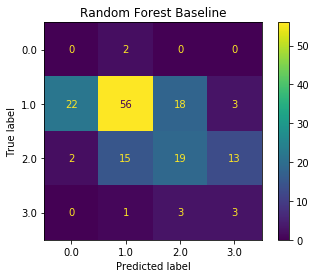

F1 Score:       0.552 
Accuracy Score: 0.497 
ROC AUC Score:  0.733


In [78]:
# check performance
get_scores(gridsearch_base, X_test_base, y_test_base, 'Random Forest Baseline')

### Random Forest with Mask Features

In [40]:
# Instantiate and gridsearch model for masked data
gridsearch_mask = GridSearchCV(estimator = rfc_mask, param_grid=grid, scoring='accuracy', cv = 5)
gridsearch_mask.fit(X_train_mask, y_train_mask);

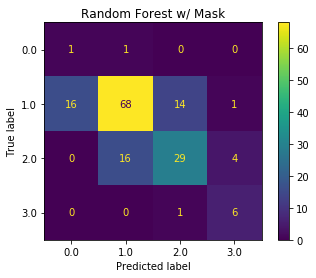

F1 Score:       0.692 
Accuracy Score: 0.662 
ROC AUC Score:  0.838


In [79]:
#check performance
get_scores(gridsearch_mask, X_test_mask, y_test_mask, 'Random Forest w/ Mask')

#### _Mask features was correlated with a difference of more than 9% for all three indicators_

## XGBoost Classifier

In [35]:
# instantiate models
xgb_base = XGBClassifier(random_state=46)
xgb_mask = XGBClassifier(random_state=46)

In [36]:
# prepare gridsearch parameter grid
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [4, 5, 6, 10],
    'min_child_weight': [1, 2, 5,7],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

In [42]:
# instantiate and fit gridsearch for baseline data
grid_xg_base = GridSearchCV(estimator = xgb_base, param_grid=param_grid, scoring = 'accuracy', cv= 3)
grid_xg_base.fit(X_train_base, y_train_base);

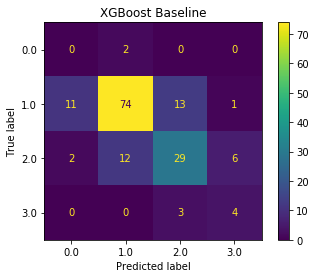

F1 Score:       0.711 
Accuracy Score: 0.682 
ROC AUC Score:  0.801


In [80]:
# check performance
get_scores(grid_xg_base, X_test_base, y_test_base, 'XGBoost Baseline')

### XGBoost with Mask Features



In [44]:
# instantiate and fit gridsearch for mask data
grid_xg_mask = GridSearchCV(estimator = xgb_mask, param_grid=param_grid, scoring = 'accuracy', cv= 3)
grid_xg_mask.fit(X_train_mask, y_train_mask);

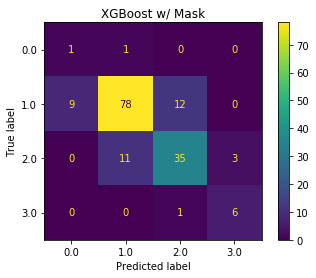

F1 Score:       0.781 
Accuracy Score: 0.764 
ROC AUC Score:  0.889


In [81]:
# check performance
get_scores(grid_xg_mask, X_test_mask, y_test_mask, 'XGBoost w/ Mask')

#### _Mask features was correlated with a difference of more than 6% for all three indicators_

## Logistic Regression Classifier

In [46]:
# instantiate models
lr_base = LogisticRegression(random_state=46, solver = 'liblinear', C= 1e12)
lr_mask = LogisticRegression(random_state=46, solver = 'liblinear', C= 1e12)

In [47]:
# fit baseline data to model
lr_base.fit(X_train_base, y_train_base);

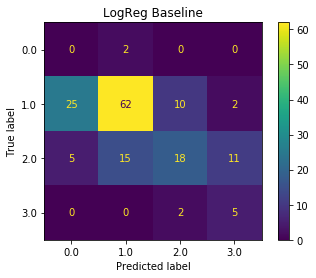

F1 Score:       0.599 
Accuracy Score: 0.541 
ROC AUC Score:  0.739


In [82]:
# check performance 
get_scores(lr_base, X_test_base, y_test_base, 'LogReg Baseline')

### Logistic Regression with mask features

In [49]:
# fit model
lr_mask.fit(X_train_mask, y_train_mask);

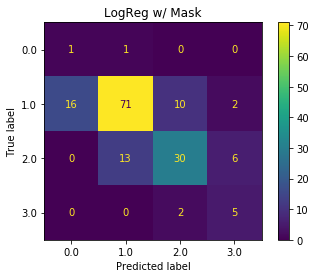

F1 Score:       0.716 
Accuracy Score: 0.682 
ROC AUC Score:  0.82


In [83]:
# check performance
get_scores(lr_mask, X_test_mask, y_test_mask, 'LogReg w/ Mask')

#### _Mask features was correlated with a difference of more than 9% for all three indicators_

#### Show model coefficients for interpretability

In [87]:
pd.DataFrame(lr_mask.coef_, columns = X_mask.columns, index = ['Red County', 'Lean Red', 'Lean Blue', 'Blue County'])

,TotalPop,total_votes16,Median_Hou,Unemployme,NonHispWhP,RUCC_2013,Age_Less15,Age_15_24,Age_25_34,Age_35_64,Age_65_74,Age_85,Age_80_84,Age_75_79,Age_70_74,Age_65_69,ind_mask,oth_mask
Red County,6.403654,-33.472272,-0.746540,-1.059445,14.611780,-0.310448,11.235103,-22.039440,-20.776615,27.677399,-3.140200,-24.034059,31.756747,4.487726,15.874370,-40.411438,-0.141757,-1.626449
Lean Red,-1.073499,-1.234349,-0.337966,0.583218,4.782177,-0.098873,7.678749,-6.667187,-4.962609,0.948632,-11.741358,-6.314887,6.249051,9.500460,-4.700517,3.598121,-1.113177,1.474773
Lean Blue,-0.496210,0.210612,-0.506278,-0.476669,0.170433,0.116258,7.013946,3.345486,-6.595248,-1.329314,-5.207066,-3.581049,6.230356,1.772157,-1.969669,1.851364,-0.015230,1.549788
Blue County,-3.854785,15.287607,-0.814285,2.042252,-12.956654,-4.282669,-49.532692,-1.639935,10.159130,22.445244,-14.674812,21.712843,-41.674085,-19.812658,-6.297757,68.807526,15.513653,0.483327


# Sources

Data from Delphi COVIDcast. Obtained via the Delphi Epidata API. <br>
https://cmu-delphi.github.io/delphi-epidata/api/covidcast.html

Data from US Department of Agriculture <br>
https://www.ers.usda.gov/data-products/rural-urban-continuum-codes/documentation/#referencedate

Data from Kaggle<br>
https://www.kaggle.com/etsc9287/2020-general-election-polls

Data from ArcGIS:<br>
https://opendata.arcgis.com/datasets/4cb598ae041348fb92270f102a6783cb_0.geojson
